In [14]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from Kitti import *
from scipy.ndimage import sobel

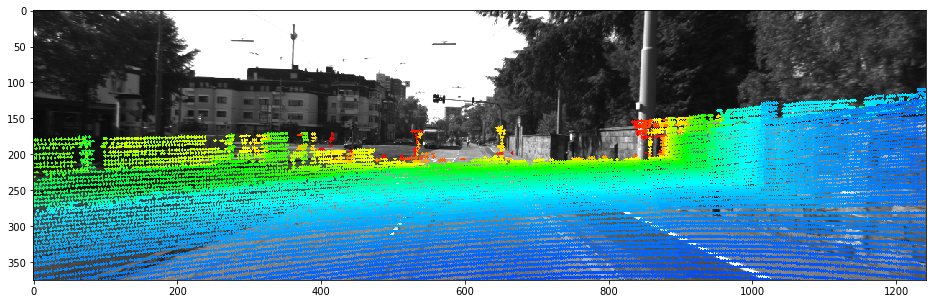

In [3]:
img, pnt, proj, depth = project('2011_09_26/2011_09_26_drive_0002_sync/', '2011_09_26/', frame=59, r_cor=np.array([.3, .05, 0]), t_cor=np.array([-1.1, 0, 0]))
f = plt.figure(figsize=(16, 12))
plt.imshow(proj);

In [4]:
h, w, c = img.shape
dimg = np.zeros((h, w))

In [5]:
def inpaint(points, color, image):
    """ project converted velodyne points into camera image """
    image = np.copy(image)
    for i in range(points.shape[1]):
        cv2.circle(image, (int(points[0][i]), int(points[1][i])), 7, (int(color[i].round()), 0, 0), -1)

    return image

In [6]:
reliable_xy = pnt.round().astype(int).T
img_idx = np.where((reliable_xy[:, 0] >= 0) & (reliable_xy[:, 0] < w) & (reliable_xy[:, 1] >= 0) & (reliable_xy[:, 1] < h))
img_xy = reliable_xy[img_idx]

In [64]:
r = inpaint(pnt, depth, dimg)

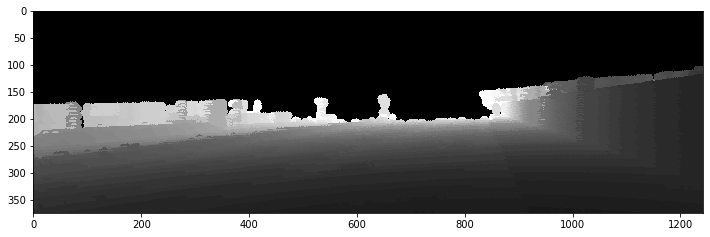

In [9]:
plt.figure(figsize=(12, 10))
plt.imshow(r, cmap=plt.cm.Greys_r);

In [10]:
def edges(img):
    dx = sobel(img, axis=0, mode='constant')
    dy = sobel(img, axis=1, mode='constant')
    sob = np.hypot(dx, dy)
    return dx, dy, sob

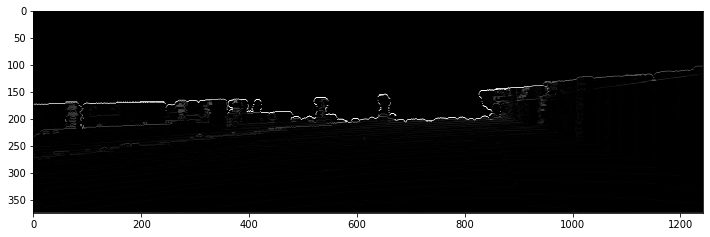

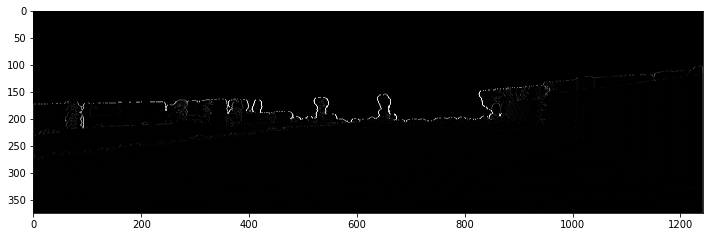

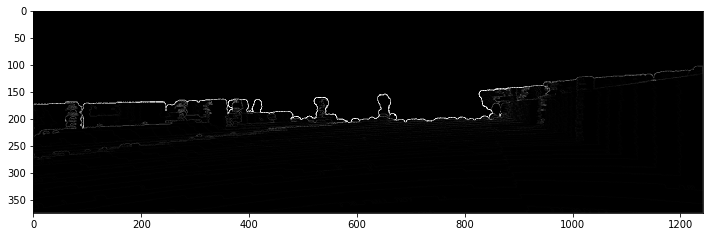

In [15]:
plt.figure(figsize=(12, 10))

dx, dy, sob = edges(r)
plt.imshow(np.abs(dx), cmap=plt.cm.Greys_r)
plt.show();
plt.figure(figsize=(12, 10))
plt.imshow(np.abs(dy), cmap=plt.cm.Greys_r);
plt.show();
plt.figure(figsize=(12, 10))
plt.imshow(np.abs(dy) + np.abs(dx), cmap=plt.cm.Greys_r);
plt.show();

In [25]:
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(float)

In [26]:
img_dx, img_dy, img_sob = edges(img_gray)

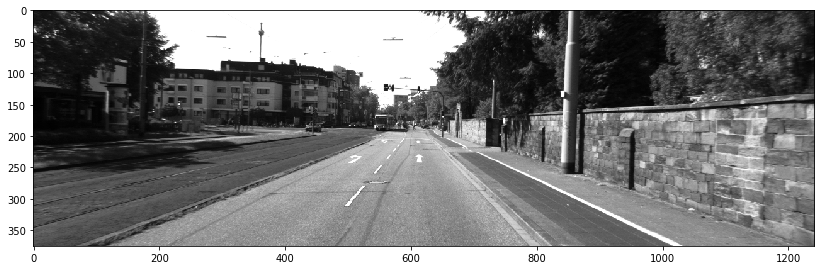

In [27]:
plt.figure(figsize=(14, 10))
plt.imshow(img_gray, cmap=plt.cm.Greys_r);

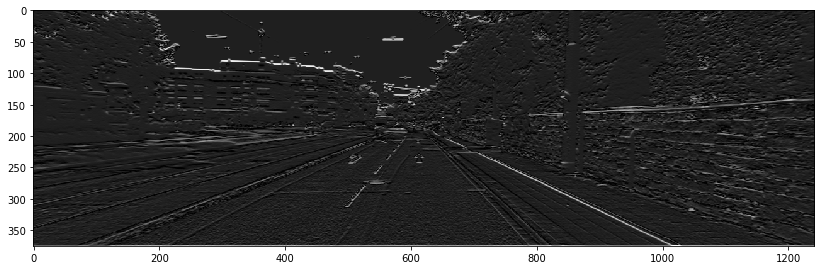

In [28]:
plt.figure(figsize=(14, 10))
plt.imshow(np.abs(img_dx - 122), cmap=plt.cm.Greys_r);

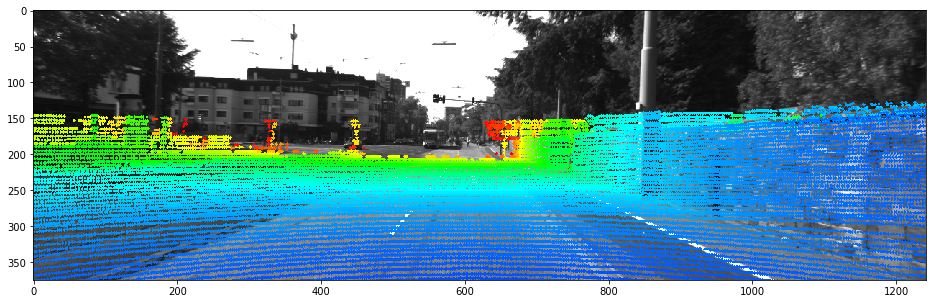

In [35]:
img, pnt, proj, depth = project('2011_09_26/2011_09_26_drive_0002_sync/', '2011_09_26/', frame=59, t_cor=t, r_cor=r)
plt.figure(figsize=(16, 14))
plt.imshow(proj);

In [36]:
def permute(r, t, strategy='all', r_scale=0.01, t_scale=0.01):
    r = np.copy(r)
    t = np.copy(t)
    if strategy == 'all':
        r = r + np.random.randn(3) * r_scale
        t = t + np.random.randn(3) * t_scale
    elif strategy == 'sequential':
        if np.random.rand() < .5:
            r = r + np.random.randn(3) * r_scale
        else:
            t = t + np.random.randn(3) * t_scale
    elif strategy == 'sparse':
        i = np.random.randint(3)
        if np.random.rand() < .5:
            r[i] = r[i] + np.random.randn() * r_scale
        else:
            t[i] = t[i] + np.random.randn() * t_scale
    return r, t

In [99]:
def evaluate(r, t, gamma=0.001):
    """ Obtain F-score for a specific values of parameters r and t """
    img, pnt, proj, depth = project('2011_09_26/2011_09_26_drive_0002_sync/', '2011_09_26/', frame=59, r_cor=r, t_cor=t)
    h, w, c = img.shape
    dimg = np.zeros((h, w))
    ddense = inpaint(pnt, depth, dimg)
    reliable_xy = pnt.round().astype(int).T
    img_idx = np.where((reliable_xy[:, 0] >= 0) & (reliable_xy[:, 0] < w) & (reliable_xy[:, 1] >= 0) & (reliable_xy[:, 1] < h))
    img_xy = reliable_xy[img_idx]
    depth_dx, depth_dy, depth_sob = edges(ddense)
    
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(float)
    img_dx, img_dy, img_sob = edges(img_gray)
    
    dx_w = img_dx.T[img_xy[:, 0], img_xy[:, 1]].astype(float)
    dx_w = np.exp(-gamma * np.abs(dx_w))
    
    rel_depth_grads = depth_dx.T[img_xy[:, 0], img_xy[:, 1]]
    rel_depth_grads = np.abs(rel_depth_grads)
    
    A = 0
    N = 0
    A += (rel_depth_grads * dx_w).sum()
    N += dx_w.sum() * rel_depth_grads.sum()
    
    dy_w = img_dy.T[img_xy[:, 0], img_xy[:, 1]].astype(float)
    dy_w = np.exp(-gamma * np.abs(dy_w))
    
    rel_depth_grads = depth_dy.T[img_xy[:, 0], img_xy[:, 1]]
    rel_depth_grads = np.abs(rel_depth_grads)
    
    A += (rel_depth_grads * dy_w).sum()
    N += dy_w.sum() * rel_depth_grads.sum()
#     A = (rel_depth_grads * img_w).sum()
#     N = img_w.sum() * np.abs(rel_depth_grads).sum()
    F = A / N
    return F

In [100]:
r, t = np.zeros(3), np.zeros(3)
best_r, best_t, best_score = r, t, None

In [101]:
r_try, t_try = permute(r, t)
evaluate(r_try, t_try)

5.3391522422228223e-05

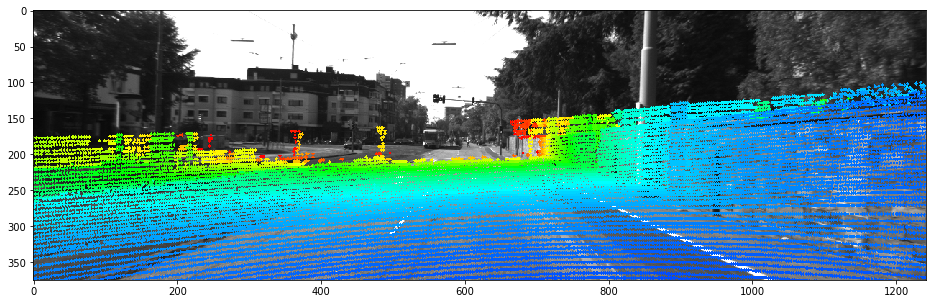

In [74]:
r_bias = np.array([0.05, .05, -.01])
t_bias = np.array([0, 0.01, -0.05])
img, pnt, proj, depth = project('2011_09_26/2011_09_26_drive_0002_sync/', '2011_09_26/', frame=59, t_cor=t_bias, r_cor=r_bias)
plt.figure(figsize=(16, 14))
plt.imshow(proj);

In [75]:
r, t = np.zeros(3), np.zeros(3)
error_log = []
update_log = []
seed = 42
n_iter = 100
prev_score = evaluate(r + r_bias, t + t_bias)
best_score = None
accept_worse = True
np.random.seed(seed)
print(f'[iteration]: R | T | Score')
for temperature in range(1, n_iter + 1):
    r_candidate, t_candidate = permute(r, t, strategy='sparse', r_scale=.01, t_scale=.01)
    score = evaluate(r_candidate + r_bias, t_candidate + t_bias)
    if score < prev_score:
        print(f"Random search improved: {score:.8f} < {prev_score:.8f}")
        print(f'[{temperature}]: {r_candidate} | {t_candidate} | {score}')
        r = r_candidate
        t = t_candidate
        if best_score is None or best_score > score:
            best_score = score
            best_r = r
            best_t = t
            error_log.append(((best_r - r_bias) ** 2 + (best_t - t_bias) ** 2).sum())
            update_log.append(temperature)
        prev_score = score
    elif accept_worse:
        p = np.exp(-(score - prev_score) * 2000000 / temperature)
#         print("Probability:", p)
        if np.random.rand() > p:
            print(f"Accepting worse candidate with P={p} and score={score}")
            r, t = r_candidate, t_candidate
            prev_score = score

best_r, best_t

[iteration]: R | T | Score
Random search improved: 0.00005360 < 0.00005387
[1]: [0. 0. 0.] | [0.         0.         0.02718716] | 5.360027540195132e-05
Random search improved: 0.00005343 < 0.00005360
[2]: [-0.03077149  0.          0.        ] | [0.         0.         0.02718716] | 5.342546741755827e-05
Random search improved: 0.00005189 < 0.00005343
[3]: [-0.03077149  0.         -0.10054814] | [0.         0.         0.02718716] | 5.18889068030928e-05
Random search improved: 0.00005176 < 0.00005189
[4]: [-0.03077149  0.         -0.12518832] | [0.         0.         0.02718716] | 5.175634511135553e-05
Random search improved: 0.00005174 < 0.00005176
[5]: [-0.03077149  0.         -0.12518832] | [0.         0.00111109 0.02718716] | 5.173978569959622e-05
Random search improved: 0.00005155 < 0.00005174
[6]: [-0.03077149  0.         -0.14657796] | [0.         0.00111109 0.02718716] | 5.155096523866251e-05
Random search improved: 0.00005066 < 0.00005155
[7]: [-0.03077149  0.         -0.17805171

(array([-0.09380002, -0.04944759, -0.90860221]),
 array([-0.0836085 , -0.48310985,  0.24508046]))

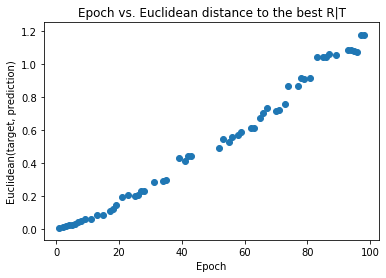

In [83]:
plt.scatter(update_log, error_log);
plt.title('Epoch vs. Euclidean distance to the best R|T')
plt.xlabel("Epoch")
plt.ylabel("Euclidean(target, prediction)");

In [84]:
r_bias = np.array([0.05, .05, -.01])
t_bias = np.array([0, 0.01, -0.05])

In [85]:
best_r, best_t

(array([-0.09380002, -0.04944759, -0.90860221]),
 array([-0.0836085 , -0.48310985,  0.24508046]))

In [86]:
r_try = -r_bias
t_try = -t_bias

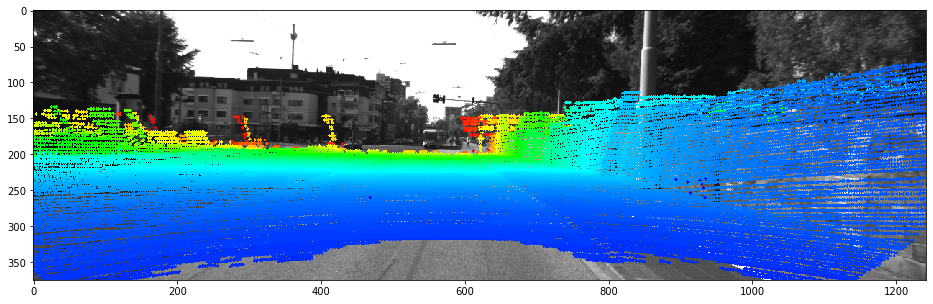

In [87]:
img, pnt, proj, depth = project('2011_09_26/2011_09_26_drive_0002_sync/', '2011_09_26/', frame=59, t_cor=best_t + t_bias, r_cor=best_r + r_bias)
plt.figure(figsize=(16, 14))
plt.imshow(proj);

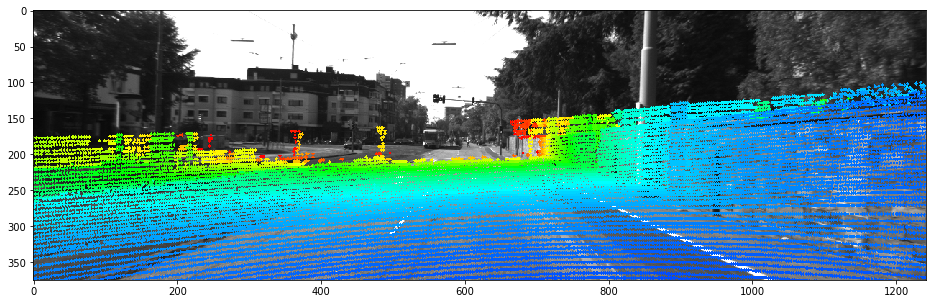

In [88]:
img, pnt, proj, depth = project('2011_09_26/2011_09_26_drive_0002_sync/', '2011_09_26/', frame=59, t_cor=t_bias, r_cor=r_bias)
plt.figure(figsize=(16, 14))
plt.imshow(proj);

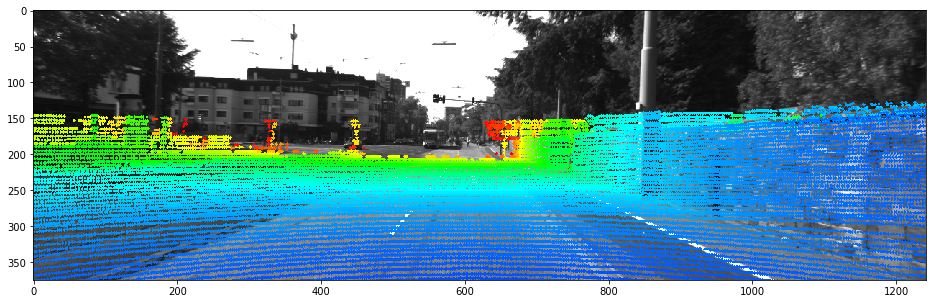

In [89]:
img, pnt, proj, depth = project('2011_09_26/2011_09_26_drive_0002_sync/', '2011_09_26/', frame=59)
plt.figure(figsize=(16, 14))
plt.imshow(proj);